In [2]:
# hide
# all_slow

In [3]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [4]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [1]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Grid Generation Tutorial

> A basic introduction to Geospatial Grids

## Basic Usage
Creating a grid from a geojson file

In [2]:
# hide
import warnings

from IPython.display import display

warnings.filterwarnings("ignore")

### Import `geopandas` and the `geowrangler.grids` module

In [3]:
import geopandas as gpd
import pandas as pd

from geowrangler import grids

In [8]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson

### Load a sample geojson file into pandas 


In our case, we are loading the Region 3 (Central Luzon Administrative Region) of the Philippines.

In [8]:
region3_gdf = gpd.read_file("../data/region3_admin.geojson")

This geopandas dataframe has the size: 

In [9]:
# hide_input
print(f"length of region3_gdf: {len(region3_gdf)} row(s)")

length of region3_gdf: 1 row(s)


In [10]:
display(region3_gdf)

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."


Show the original plot

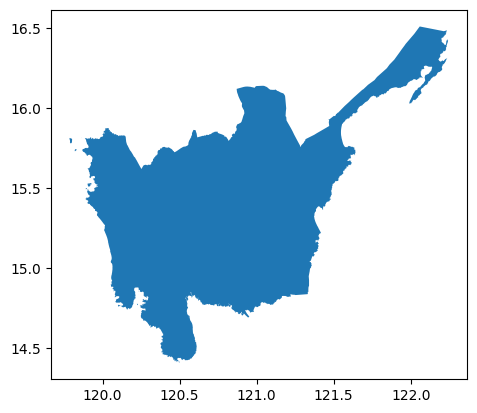

In [11]:
import matplotlib.pyplot as plt

ax = region3_gdf.plot(ax=plt.axes())

In [12]:
region3_gdf.crs  # CRS info

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
aoi_total_bounds = region3_gdf.total_bounds
aoi_total_bounds

array([119.7858332,  14.4075257, 122.2429921,  16.5092548])

## Square Grid Generator
### Creating Grids

Create a grid generator with a size of `5,000` m. 
The units of the grid size are dependent on the projection parameter  
of the grid generator. In this case, the [default is  `EPSG:3857`](https://epsg.io/3857).

In [14]:
grids.SquareGridGenerator?

Init signature:
grids.SquareGridGenerator(
    cell_size: float,
    grid_projection: str = 'EPSG:3857',
    boundary: Union[geowrangler.grids.SquareGridBoundary, List[float]] = None,
)
Docstring:      <no docstring>
File:           ~/geowrangler/geowrangler/grids.py
Type:           type
Subclasses:     


In [15]:
grid_generator5k = grids.SquareGridGenerator(5_000)  # 5 km x 5 km square cells

Generate square grids
> Notice the time taken to grid the multi polygon at 5K resolution


In [16]:
%%time
# slow
grid_gdf5k = grid_generator5k.generate_grid(region3_gdf)

CPU times: user 614 ms, sys: 0 ns, total: 614 ms
Wall time: 617 ms


<AxesSubplot:>

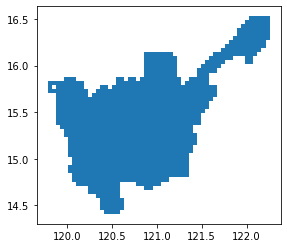

In [17]:
grid_gdf5k.plot()

Show gridded version of sample geojson file at 5K resolution 

In [18]:
# hide_input
# no_test
print(f"length of grid_gdf5k: {len(grid_gdf5k)} row(s)")

length of grid_gdf5k: 1074 row(s)


In [19]:
# hide
# slow
assert len(grid_gdf5k) == 1074

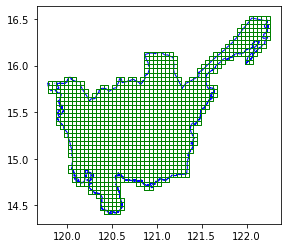

In [20]:
# slow
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k.plot(ax=ax, facecolor="none", edgecolor="green")

In addition to the grid cells, there are 2 extra columns `x` and `y` when combined are unique per grid. It can also tell us which grids are adjacent to each other. 

In [21]:
# slow
grid_gdf5k.head()

,x,y,geometry
0,7,8,"POLYGON ((120.10024 14.75528, 120.14516 14.755..."
1,6,8,"POLYGON ((120.05533 14.75528, 120.10024 14.755..."
2,9,8,"POLYGON ((120.19008 14.75528, 120.23499 14.755..."
3,2,24,"POLYGON ((119.87566 15.44910, 119.92058 15.449..."
4,2,25,"POLYGON ((119.87566 15.49239, 119.92058 15.492..."


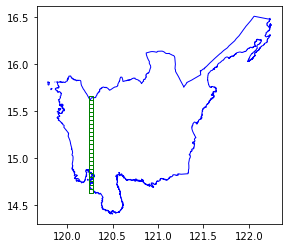

In [22]:
# slow
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k[grid_gdf5k["x"] == 10].plot(ax=ax, facecolor="none", edgecolor="green")

### Gridding at a coarser resolution
Let's try the same process but with a bigger grid (15K)

In [23]:
grid_generator15k = grids.SquareGridGenerator(15_000)  # 15 km x 15 km grids

Generate square grids
> Notice the time taken to grid the multi polygon at 15K resolution (compared to 5K resolution)


In [24]:
%%time
grid_gdf15k = grid_generator15k.generate_grid(region3_gdf)

CPU times: user 548 ms, sys: 0 ns, total: 548 ms
Wall time: 547 ms


<AxesSubplot:>

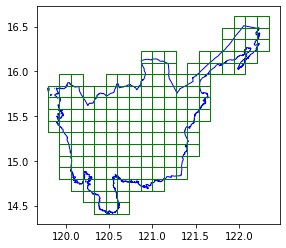

In [25]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")

Show gridded version of sample geojson file at 15K resolution 

In [26]:
# hide_input
print(f"length of grid_gdf15k: {len(grid_gdf15k)} row(s)")

length of grid_gdf15k: 154 row(s)


In [27]:
# hide
assert len(grid_gdf15k) == 154

### Reusing boundaries
If you have 2 polygons that are far from each other but wish to have them follow the reference same reference `x` and `y`, you can use pass in custom boudaries. 

Let's load some grids that are from each other

In [28]:
cell1 = grid_gdf15k.head(1)
cell2 = grid_gdf15k.tail(1)

In [29]:
pd.concat([cell1, cell2])

,x,y,geometry
0,2,2,"POLYGON ((120.05533 14.66839, 120.19008 14.668..."
153,18,16,"POLYGON ((122.21128 16.48548, 122.34603 16.485..."


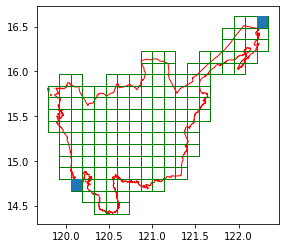

In [30]:
ax = region3_gdf.plot(facecolor="none", edgecolor="red")
ax = grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")
ax = pd.concat([cell1, cell2]).plot(ax=ax)

In [31]:
grid_generator1k = grids.SquareGridGenerator(1_000, boundary=aoi_total_bounds)

In [32]:
%%time
gridcell1 = grid_generator1k.generate_grid(cell1)

CPU times: user 27.1 ms, sys: 0 ns, total: 27.1 ms
Wall time: 27.8 ms


In [33]:
len(gridcell1)

272

In [34]:
gridcell1.head()

,x,y,geometry
0,29,30,"POLYGON ((120.04634 14.66839, 120.05533 14.668..."
1,29,31,"POLYGON ((120.04634 14.67708, 120.05533 14.677..."
2,29,32,"POLYGON ((120.04634 14.68577, 120.05533 14.685..."
3,29,33,"POLYGON ((120.04634 14.69446, 120.05533 14.694..."
4,29,34,"POLYGON ((120.04634 14.70315, 120.05533 14.703..."


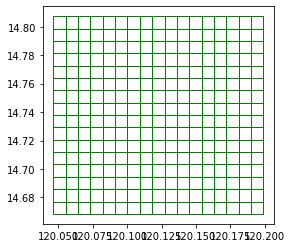

In [35]:
ax = gridcell1.plot(facecolor="none", edgecolor="green")

In [36]:
%%time
gridcell2 = grid_generator1k.generate_grid(cell2)

CPU times: user 20.2 ms, sys: 0 ns, total: 20.2 ms
Wall time: 18.7 ms


In [37]:
len(gridcell2)

20

In [38]:
gridcell2.head()

,x,y,geometry
0,269,239,"POLYGON ((122.20230 16.47686, 122.21128 16.476..."
1,269,240,"POLYGON ((122.20230 16.48548, 122.21128 16.485..."
2,269,241,"POLYGON ((122.20230 16.49409, 122.21128 16.494..."
3,269,242,"POLYGON ((122.20230 16.50270, 122.21128 16.502..."
4,270,239,"POLYGON ((122.21128 16.47686, 122.22027 16.476..."


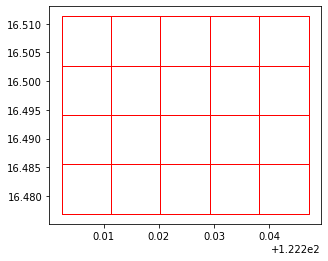

In [39]:
ax = gridcell2.plot(facecolor="none", edgecolor="red")

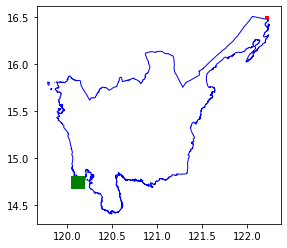

In [40]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = gridcell1.plot(ax=ax, color="green")
ax = gridcell2.plot(ax=ax, color="red")

## Generating grids for multiple distant areas
If you are using AOIs that are vary far from each other, Grid Generator already optmizes the implementation for you


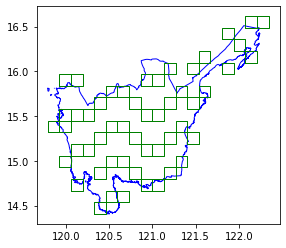

In [41]:
sparse_aois = grid_gdf15k.iloc[
    0:1000:3,
]  # Get areas that far from each other
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_aois.plot(ax=ax, facecolor="none", edgecolor="green")

In [42]:
sparse_grid = grid_generator1k.generate_grid(sparse_aois)

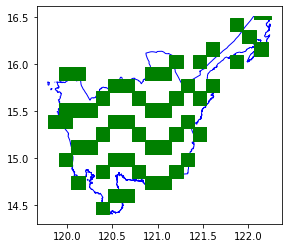

In [43]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_grid.plot(ax=ax, facecolor="none", edgecolor="green")

It is a bit hard to see the grids so, we get a subset to verify.

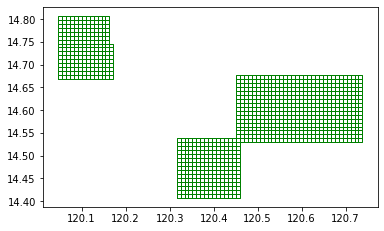

In [44]:
ax = sparse_grid.head(1000).plot(facecolor="none", edgecolor="green")

## H3 Grid Generator
### Generating grids
Let us generate grids of resolution 5. To learn more about the different resolution, visit: https://h3geo.org/docs/core-library/restable/

In [45]:
h3_generator = grids.H3GridGenerator(resolution=5)

In [46]:
%%time
h3_5_gdf = h3_generator.generate_grid(region3_gdf)

CPU times: user 2.79 s, sys: 6.39 ms, total: 2.8 s
Wall time: 2.81 s


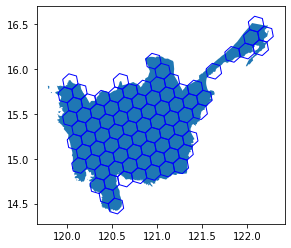

In [47]:
ax = region3_gdf.plot(aspect="equal")
ax = h3_5_gdf.plot(ax=ax, facecolor="none", edgecolor="blue", aspect="equal")

### Not exporting geometry
If you do not plan to use use geometry, you can pass `return_geometry=False` to just get a normal pandas DataFrame with the ids.

In [48]:
h3_generator_no_geom = grids.H3GridGenerator(resolution=5, return_geometry=False)

In [49]:
%%time
h3_region3_no_geom = h3_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 2.75 s, sys: 26.9 ms, total: 2.78 s
Wall time: 2.78 s


In [50]:
len(h3_region3_no_geom)

84

In [51]:
h3_region3_no_geom.head()

,hex_id
0,85694103fffffff
1,856941d7fffffff
2,85694e83fffffff
3,85694e93fffffff
4,85694387fffffff


## Bing Tile Grid Generator
### Generating grids
Let us generate grids of zoom_level 12. To learn more about the different resolution, visit: https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system

In [12]:
bing_tile_grid_generator = grids.BingTileGridGenerator(18)

In [38]:
%%time
# slow
bing_tile_gdf = bing_tile_grid_generator.generate_grid(region3_gdf)

qk 13230303033010
[13230303033010]
qk 13230303033001
qk 13230303033010
[13230303033001, 13230303033010]
qk 13230303033111
[13230303033111]
qk 13230303031333
qk 13230303033111
[13230303031333, 13230303033111]
qk 13230301230202
qk 13230301230220
[13230301230202, 13230301230220]
qk 13230301230200
qk 13230301230202
qk 13230301230201
qk 13230301230203
qk 13230301230210
qk 13230301230212
[13230301230200, 13230301230202, 13230301230201, 13230301230203, 13230301230210, 13230301230212]
qk 13230301203121
qk 13230301203123
[13230301203121, 13230301203123]
qk 13230301201233
qk 13230301203011
qk 13230301201322
qk 13230301203100
[13230301201233, 13230301203011, 13230301201322, 13230301203100]
qk 13230301201333
[13230301201333]
qk 13230303031313
qk 13230303120202
[13230303031313, 13230303120202]
qk 13230303031311
[13230303031311]
qk 13230301001331
qk 13230301001333
qk 13230301003111
qk 13230301003113
qk 13230301003131
qk 13230301003133
qk 13230301003311
qk 13230301003313
qk 13230301003331
qk 13230301

In [13]:
%%time
# slow
bing_tile_join_gdf = bing_tile_grid_generator.generate_grid_join(region3_gdf)

else
filter
n_workers 8
after array_split
after [(tile_item, reprojected_gdf) for tile_item in tile_items]
len(items) 8


after intersect_tiles_gdf
after tiles_gdf
CPU times: user 4h 42min 55s, sys: 1min 23s, total: 4h 44min 19s
Wall time: 52min 33s


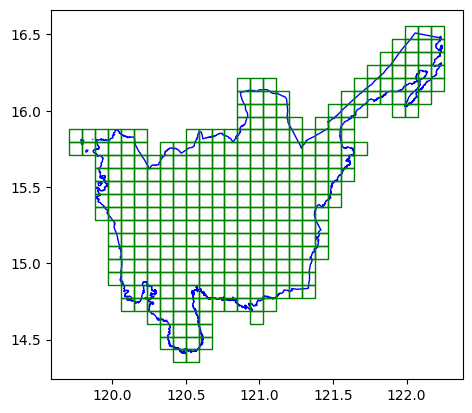

In [16]:
# no_test
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = bing_tile_gdf.plot(ax=ax, facecolor="none", edgecolor="green")

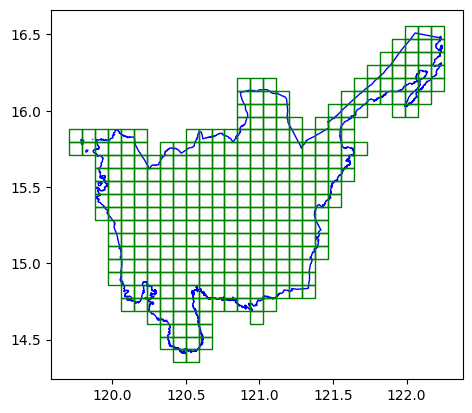

In [17]:
# no_test
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = bing_tile_join_gdf.plot(ax=ax, facecolor="none", edgecolor="green")

### Not exporting geometry

If you do not plan to use use geometry, you can pass return_geometry=False to just get a normal pandas DataFrame with the ids.


In [55]:
bing_tile_grid_generator_no_geom = grids.BingTileGridGenerator(
    12, return_geometry=False
)

In [56]:
%%time
# slow
bing_region3_keys = bing_tile_grid_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 7.45 s, sys: 7.19 ms, total: 7.45 s
Wall time: 7.45 s


In [57]:
# no_test
bing_region3_keys.head()

,quadkey
0,132303030330
1,132303030331
2,132303030313
3,132303012302
4,132303012031


### Converting quadkey to x,y,z format

If you need to convert the quadkey to x,y format, you can pass add_xyz_cols=True to add the x and y columns to the returned dataframe. 

In [65]:
bing_tile_grid_generator_add_xyz = grids.BingTileGridGenerator(12, add_xyz_cols=True)

In [66]:
%%time
# slow
bing_region3_keys = bing_tile_grid_generator_add_xyz.generate_grid(region3_gdf)

CPU times: user 8.85 s, sys: 20 ms, total: 8.87 s
Wall time: 8.87 s


In [67]:
# no_test
bing_region3_keys.head()

,quadkey,x,y,z,geometry
0,132303030330,3414,1878,12,"POLYGON ((120.05859 14.68988, 120.05859 14.774..."
1,132303030331,3415,1878,12,"POLYGON ((120.14648 14.68988, 120.14648 14.774..."
2,132303030313,3415,1877,12,"POLYGON ((120.14648 14.77488, 120.14648 14.859..."
3,132303012302,3412,1869,12,"POLYGON ((119.88281 15.45368, 119.88281 15.538..."
4,132303012031,3411,1866,12,"POLYGON ((119.79492 15.70766, 119.79492 15.792..."


# From Retail Demo Data Processing

In [4]:
# standard imports
import os
import sys

# Geospatial processing packages
import geopandas as gpd
import numpy as np
import pandas as pd
import pandas_gbq as gbq
import requests
from shapely import wkt
from shapely.geometry.polygon import orient

import geowrangler.spatialjoin_highest_intersection as spatial_join

# from geowrangler import spatialjoin_highest_intersection
from geowrangler import grids
from geowrangler.validation import GeometryValidation

In [5]:
DATA_DIR = "./data"
GCP_PROJ_ID = "geo-retail-data-mart"
ADMIN_BOUNDS_ID = GCP_PROJ_ID + ".00_raw_data" + ".wadm_adminbounds"
GRID_ZOOM18_ID = GCP_PROJ_ID + ".01_aoi" + ".grid_zoom18_unfiltered"

In [8]:
%%time

response = requests.get(f"https://www.geoboundaries.org/api/current/gbOpen/PHL/ADM0/")
simplified_geojson_url = response.json()["simplifiedGeometryGeoJSON"]
adm0_df = gpd.read_file(simplified_geojson_url, dialect="standard")
adm0_gdf = gpd.GeoDataFrame(adm0_df, crs="EPSG:4326")

adm0_gdf.head()

CPU times: user 379 ms, sys: 82.7 ms, total: 461 ms
Wall time: 5.71 s


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,The Philippines,,24100683B85265433280220,PHL,ADM0,"MULTIPOLYGON (((119.46876 4.59360, 119.46771 4..."


In [7]:
# define table schema
table_schema = [
    {"name": "shapeName", "type": "STRING"},
    {"name": "shapeISO", "type": "STRING"},
    {"name": "shapeID", "type": "STRING"},
    {"name": "shapeGroup", "type": "STRING"},
    {"name": "shapeType", "type": "STRING"},
    {"name": "geometry", "type": "GEOGRAPHY"},
]

# upload to big query
gbq.to_gbq(
    adm0_gdf,
    GCP_PROJ_ID + ".00_daw_data" + ".wadm0",
    project_id="tm-geospatial",
    if_exists="replace",
    table_schema=table_schema,
    progress_bar=True,
    # chunksize=10000,  # chunk the upload to stay within BQ limits
    api_method="load_csv",  # chunksize only works if load_csv (default is load_parquet)
)

NameError: name 'adm0_gdf' is not defined

In [11]:
ax = adm0_gdf.plot(ax=plt.axes())

NameError: name 'plt' is not defined

In [24]:
%%time

# query for subset of adm_zone
admin_bounds_query = f"""
  SELECT *
  FROM
  `{ADMIN_BOUNDS_ID}`
  """
# convert from adm_zone table to gdf
admin_bounds_df = gbq.read_gbq(admin_bounds_query, GCP_PROJ_ID, dialect="standard")
admin_bounds_gdf = gpd.GeoDataFrame(
    admin_bounds_df, geometry=admin_bounds_df.geometry.apply(wkt.loads), crs="EPSG:4326"
)
admin_bounds_gdf

CPU times: user 10.8 s, sys: 3.56 s, total: 14.3 s
Wall time: 13min


,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_PCODE,ADM3_EN,ADM4_PCODE,ADM4_EN,geometry
0,PH010000000,Region I,PH012900000,Ilocos Sur,PH012902000,Banayoyo,PH012902001,Bagbagotot,"POLYGON ((120.47455 17.24173, 120.48017 17.256..."
1,PH030000000,Region III,PH034900000,Nueva Ecija,PH034901000,Aliaga,PH034901040,Sunson,"POLYGON ((120.88854 15.53573, 120.88847 15.535..."
2,PH030000000,Region III,PH031400000,Bulacan,PH031419000,San Ildefonso,PH031419003,Anyatam,"POLYGON ((120.95109 15.10801, 120.94721 15.107..."
3,PH080000000,Region VIII,PH084800000,Northern Samar,PH084803000,Bobon,PH084803010,Magsaysay (Doce),"POLYGON ((124.57423 12.52646, 124.57410 12.526..."
4,PH130000000,National Capital Region,PH133900000,"NCR, City of Manila, First District",PH133914000,Santa Ana,PH133914064,Barangay 866,"POLYGON ((121.00560 14.58634, 121.00502 14.585..."
...,...,...,...,...,...,...,...,...,...
42052,PH030000000,Region III,PH037100000,Zambales,PH037104000,Castillejos,PH037104004,Looc,"POLYGON ((120.16690 14.92229, 120.16310 14.922..."
42053,PH150000000,Autonomous Region in Muslim Mindanao,PH153600000,Lanao del Sur,PH153609000,Ganassi,PH153609018,Poblacion,"POLYGON ((124.10172 7.82757, 124.10092 7.82778..."
42054,PH080000000,Region VIII,PH086400000,Southern Leyte,PH086417000,Sogod,PH086417033,Salvacion,"POLYGON ((125.00928 10.39132, 125.00893 10.391..."
42055,PH090000000,Region IX,PH097200000,Zamboanga del Norte,PH097221000,Tampilisan,PH097221001,Cabong,"POLYGON ((122.70810 7.91198, 122.70781 7.91594..."


'1925/1926'

'geom'

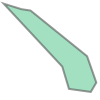

before zip tiles.items
before zip geom_tile
before add_xyz_cols
CPU times: user 30min 43s, sys: 10min 52s, total: 41min 35s
Wall time: 2h 12min 47s


,quadkey,x,y,z,geometry
0,132323003120230030,217874,127666,18,"POLYGON ((119.20441 4.67087, 119.20441 4.67224..."
1,132323003120230032,217874,127667,18,"POLYGON ((119.20441 4.66950, 119.20441 4.67087..."
2,132323003120230210,217874,127668,18,"POLYGON ((119.20441 4.66814, 119.20441 4.66950..."
3,132323003120230031,217875,127666,18,"POLYGON ((119.20578 4.67087, 119.20578 4.67224..."
4,132323003120230033,217875,127667,18,"POLYGON ((119.20578 4.66950, 119.20578 4.67087..."
...,...,...,...,...,...
35515605,132330010103322212,222562,123005,18,"POLYGON ((125.64240 11.00860, 125.64240 11.009..."
35515606,132330010103322230,222562,123006,18,"POLYGON ((125.64240 11.00725, 125.64240 11.008..."
35515607,132330010103322213,222563,123005,18,"POLYGON ((125.64377 11.00860, 125.64377 11.009..."
35515608,132330010103322231,222563,123006,18,"POLYGON ((125.64377 11.00725, 125.64377 11.008..."


In [9]:
%%time
# set grid parameters
grid_generator = grids.BingTileGridGenerator(18, add_xyz_cols=True)

# create grid
grid_gdf = grid_generator.generate_grid(gdf=adm0_gdf)
grid_gdf

In [12]:
grid_gdf["centroid"] = grid_gdf.geometry.centroid
grid_gdf

,quadkey,x,y,z,geometry,centroid
0,132323003120230030,217874,127666,18,"POLYGON ((119.20441 4.67087, 119.20441 4.67224...",POINT (119.20509 4.67156)
1,132323003120230032,217874,127667,18,"POLYGON ((119.20441 4.66950, 119.20441 4.67087...",POINT (119.20509 4.67019)
2,132323003120230210,217874,127668,18,"POLYGON ((119.20441 4.66814, 119.20441 4.66950...",POINT (119.20509 4.66882)
3,132323003120230031,217875,127666,18,"POLYGON ((119.20578 4.67087, 119.20578 4.67224...",POINT (119.20647 4.67156)
4,132323003120230033,217875,127667,18,"POLYGON ((119.20578 4.66950, 119.20578 4.67087...",POINT (119.20647 4.67019)
...,...,...,...,...,...,...
35515605,132330010103322212,222562,123005,18,"POLYGON ((125.64240 11.00860, 125.64240 11.009...",POINT (125.64308 11.00927)
35515606,132330010103322230,222562,123006,18,"POLYGON ((125.64240 11.00725, 125.64240 11.008...",POINT (125.64308 11.00793)
35515607,132330010103322213,222563,123005,18,"POLYGON ((125.64377 11.00860, 125.64377 11.009...",POINT (125.64445 11.00927)
35515608,132330010103322231,222563,123006,18,"POLYGON ((125.64377 11.00725, 125.64377 11.008...",POINT (125.64445 11.00793)


In [14]:
# define table schema
table_schema = [
    {"name": "quadkey", "type": "STRING"},
    {"name": "geometry", "type": "GEOGRAPHY"},
    {"name": "x", "type": "INTEGER"},
    {"name": "y", "type": "INTEGER"},
    {"name": "z", "type": "INTEGER"},
    {"name": "centroid", "type": "GEOGRAPHY"},
]

# upload to big query
gbq.to_gbq(
    grid_gdf,
    GRID_ZOOM18_ID,
    project_id=GCP_PROJ_ID,
    if_exists="replace",
    table_schema=table_schema,
    progress_bar=True,
    # chunksize=10000,  # chunk the upload to stay within BQ limits
    api_method="load_csv",  # chunksize only works if load_csv (default is load_parquet)
)

In [ ]:
# spatial join using highest intersection
grid_wadm_gdf_32651 = spatial_join.get_highest_intersection(
    grid_gdf, admin_bounds_gdf, "EPSG:32651"
)

# convert back to epsg 4326
grid_wadm_gdf = grid_wadm_gdf_32651.to_crs(epsg=4326)

# retain only relevant columns
grid_wadm_gdf = grid_wadm_gdf[
    [
        "quadkey",
        "ADM1_PCODE",
        "ADM1_EN",
        "ADM2_PCODE",
        "ADM2_EN",
        "ADM3_PCODE",
        "ADM3_EN",
        "ADM4_PCODE",
        "ADM4_EN",
        "geometry",
    ]
]
grid_wadm_gdf

In [ ]:
# validate geometry
validated_gdf = GeometryValidation(grid_wadm_gdf).validate_all()
validated_gdf = validated_gdf[
    [
        "quadkey",
        "ADM1_PCODE",
        "ADM1_EN",
        "ADM2_PCODE",
        "ADM2_EN",
        "ADM3_PCODE",
        "ADM3_EN",
        "ADM4_PCODE",
        "ADM4_EN",
        "geometry",
    ]
]
validated_gdf

In [ ]:
null_count = validated_gdf["ADM4_EN"].isnull().sum()
if null_count > 0:
    print("There are", null_count, "null values in the ADM4_EN column.")
else:
    print("There are no null values in the ADM4_EN column.")

In [ ]:
validated_gdf.info()

In [ ]:
# Create the folder if it doesn't exist
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Save as CSV
csv_filename = os.path.join(DATA_DIR, "grid_wadm_zoom18.csv")
validated_gdf.to_csv(csv_filename, index=False)

# Save as pickle
pickle_filename = os.path.join(DATA_DIR, "grid_wadm_zoom18.pkl")
validated_gdf.to_pickle(pickle_filename)

In [ ]:
# open the pickle file as geodataframe
pkl_file = os.path.join(DATA_DIR, "grid_wadm_zoom18.pkl")
validated_df = pd.read_pickle(pkl_file)
validated_gdf = gpd.GeoDataFrame(validated_df)
validated_gdf

In [ ]:
# define table schema
table_schema = [
    {"name": "quadkey", "type": "STRING"},
    {"name": "ADM1_EN", "type": "STRING"},
    {"name": "ADM1_PCODE", "type": "STRING"},
    {"name": "ADM2_EN", "type": "STRING"},
    {"name": "ADM2_PCODE", "type": "STRING"},
    {"name": "ADM3_EN", "type": "STRING"},
    {"name": "ADM3_PCODE", "type": "STRING"},
    {"name": "ADM4_EN", "type": "STRING"},
    {"name": "ADM4_PCODE", "type": "STRING"},
    {"name": "geometry", "type": "GEOGRAPHY"},
]

# upload to big query
gbq.to_gbq(
    validated_gdf,
    GRID_ZOOM18_ID,
    project_id="tm-geospatial",
    if_exists="replace",
    table_schema=table_schema,
    progress_bar=True,
    # chunksize=10000,  # chunk the upload to stay within BQ limits
    api_method="load_csv",  # chunksize only works if load_csv (default is load_parquet)
)